## Reptile Meta-Learning

Based on the following paper: <i>On First-Order Meta-Learning Algorithms</i>.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Dropout,Activation
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,mean_squared_error
from sklearn.utils import shuffle

### Gather data

In [2]:
universal_embed = hub.load("../other/universal-sentence-encoder_4")

In [3]:
def get_data(file_name,data_dir="../data/sentiment/"):
    """ Gather and process data
    """
    all_text = []
    all_labels = []
    with open(data_dir+file_name) as infile:
        lines = infile.readlines()
        for line in lines:
            all_labels.append(int(line[0]))
            all_text.append(line[2:])
    all_text = all_text[:2000]
    all_labels = all_labels[:2000]
    data_x = universal_embed(all_text).numpy()
    data_y = np.array(all_labels)
    return data_x,data_y

In [4]:
data_files = ["amazon_electronics_reviews/reviews.txt","amazon_kitchen_reviews/reviews.txt","amazon_toys_reviews/reviews.txt","imdb_reviews/reviews.txt","yelp_reviews/reviews.txt"]
all_data = [get_data(fn) for fn in data_files]

t_x,t_y = all_data[0] # task we are optimizing for
train_x,train_y = t_x[:100],t_y[:100]
test_x,test_y = t_x[500:],t_y[500:]

all_data = all_data[1:] # all training data
all_train_data = [(df[0][:1000],df[1][:1000]) for df in all_data]
all_test_data = [(df[0][1000:],df[1][1000:]) for df in all_data]

### Modeling

In [5]:
def get_model():
    """ Model instantiation
    """
    x = Input(shape=(512))
    h = Dense(100,activation="relu")(x)
    o = Dense(1,activation=None)(h)
    
    model = Model(inputs=x,outputs=o)
    return model

In [6]:
n_epochs = 1000
batch_size = 50
optimizer = Adam(0.001)
meta_model = get_model()
n_tasks = len(all_test_data)
n_inner_epochs=3

for epoch_i in range(n_epochs):
    all_train_data = [shuffle(df[0],df[1]) for df in all_train_data]
    all_test_data = [shuffle(df[0],df[1]) for df in all_test_data]
    
    losses = []
    for i in range(0,len(all_train_data[0]),batch_size*n_inner_epochs):
        task_train_x = [df[0][i:i+batch_size*n_inner_epochs] for df in all_train_data]
        task_train_y = [df[1][i:i+batch_size*n_inner_epochs] for df in all_train_data]
            
        task_losses = []
        for t_i in range(n_tasks):
            model_copy = get_model()
            model_copy.set_weights(meta_model.get_weights())
            
            for j in range(0,batch_size*n_inner_epochs,batch_size): # K>1 steps for task T
                with tf.GradientTape() as tape:
                    task_train_pred = model_copy(task_train_x[t_i][j:j+batch_size])
                    task_train_loss = BinaryCrossentropy()(task_train_y[t_i][j:j+batch_size],task_train_pred)
                gradients = tape.gradient(task_train_loss, model_copy.trainable_variables)
                optimizer.apply_gradients(zip(gradients,model_copy.trainable_variables))
            task_losses.append(float(task_train_loss))
            
            new_weights = [] # update the meta model parameters
            for i in range(1,len(meta_model.layers)): # first layer is input
                new_weights.append(meta_model.layers[i].kernel-0.001*(meta_model.layers[i].kernel-model_copy.layers[i].kernel))
                new_weights.append(meta_model.layers[i].bias-0.001*(meta_model.layers[i].bias-model_copy.layers[i].bias))
            meta_model.set_weights(new_weights)
            
        losses.append(sum(task_losses)/len(task_losses))
    
    if sum(losses)/len(losses)<0.7:
        break

### Validation

In [7]:
# meta-learner
model = get_model()
model.set_weights(meta_model.get_weights())
model.compile(loss=BinaryCrossentropy(),optimizer=Adam(lr=0.001))

epoch_acc_meta = []
for _ in range(50):
    model.train_on_batch(train_x,train_y)
    test_pred = model(test_x).numpy()
    test_pred[test_pred<0.5]=0
    test_pred[test_pred>=0.5]=1
    epoch_acc_meta.append(balanced_accuracy_score(test_y,test_pred))

In [8]:
# Normal learner
model = get_model()
model.compile(loss=BinaryCrossentropy(),optimizer=Adam(lr=0.001))

epoch_acc = []
for _ in range(50):
    model.train_on_batch(train_x,train_y)
    test_pred = model(test_x).numpy()
    test_pred[test_pred<0.5]=0
    test_pred[test_pred>=0.5]=1
    epoch_acc.append(balanced_accuracy_score(test_y,test_pred))

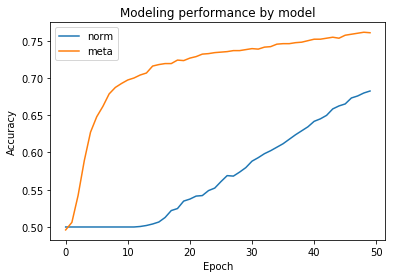

In [9]:
plt.plot([_ for _ in range(len(epoch_acc))],epoch_acc,label="norm")
plt.plot([_ for _ in range(len(epoch_acc_meta))],epoch_acc_meta,label="meta")
plt.title("Modeling performance by model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()